In [ ]:
%autosave 200

## Imports

In [14]:
import sys
import random
import numpy as np
import cv2
import math
import os
import pandas as pd
import uuid
import shutil
import pyvjoy
import pyautogui
import glob
import win32gui, win32com.client
import matplotlib.pyplot as plt
from pynput import keyboard
from time import time, sleep
from PIL import Image
from directinputs import PressKey, ReleaseKey, CTRL, eight, nine
from assetto_corsa_telemetry_reader import AssettoCorsaData
from gym import Env, spaces
from gym.spaces import Box, Discrete
from collections import deque





## Taking screenshot 

In [15]:
def take_screenshot(window_title=None):
    
    
    shell = win32com.client.Dispatch("WScript.Shell")
    shell.SendKeys('%') 
    
    if window_title:
        hwnd = win32gui.FindWindow(None, window_title)
        
        if hwnd:
            win32gui.SetForegroundWindow(hwnd)  
            sleep(0.2)
            x, y, x1, y1 = win32gui.GetClientRect(hwnd)
            x, y = win32gui.ClientToScreen(hwnd, (x, y))
            x1, y1 = win32gui.ClientToScreen(hwnd, (x1 - x, y1 - y))
            
            win32gui.SetForegroundWindow(hwnd) 
            
            frame = np.array(pyautogui.screenshot(region=(x, y, x1, y1)))
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            resize = cv2.resize(frame,(160,120), interpolation=cv2.INTER_CUBIC)
            
            return resize
        else:
            print('Window not found!')
    else:
        frame = np.array(pyautogui.screenshot())
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(frame,(256,144), interpolation=cv2.INTER_CUBIC)
        
        
        return resize


In [16]:
img=take_screenshot('Assetto corsa')
img.shape

(120, 160, 3)

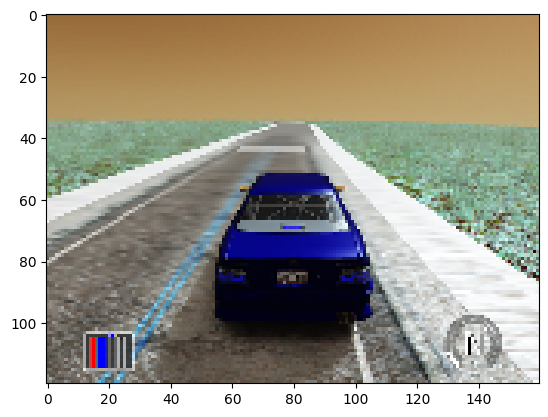

In [17]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

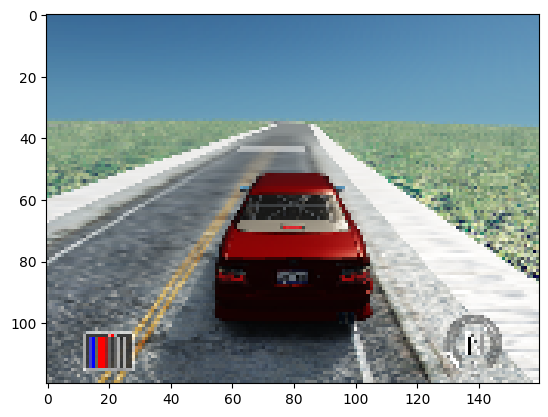

In [18]:
plt.imshow(img)

## packing telemetry data and screenshot

In [19]:
class collector():
    def __init__(self, window, async_sample=False):
        self.window = window
        self.running = True
        self.last_sample_time = time()
        self.frame = np.zeros((120, 160, 3))
        self.speed, self.onTrack, self.dmgFront, self.vel1, self.vel2, self.vel3 = [0, 0, 0, 0, 0, 0]
        self.assettoTelemetry = AssettoCorsaData()
        self.assettoTelemetry.start()
        self.async_sample= async_sample
        self._pause_acquisition = False
        if self.async_sample:
            self._sample_thread = Thread(
                target=self.sample_data, args=())
            self._sample_thread.daemon = True
            self._sample_thread.start()
    def __del__(self):
        self.stop()

    def stop(self):
        self.running = False
         
    def resume(self):
        self._pause_acquisition = False
        

    def pause(self):
        self._pause_acquisition = True
        print('Data acquisition paused')    
    
    def package_data(self):
            return self.frame
    def package_data2(self):       
            return [self.speed, self.onTrack, self.dmgFront, self.vel1, self.vel2, self.vel3 ]    
        
    def sample_data(self):
        while self.running:
            
            self.frame = np.array(take_screenshot(self.window))
                 
            new_data = self.package_data()
            
            if self.async_sample == False:
                break
            
        return new_data
    def sample_data2(self):
        while self.running:
            
            telemetry_data = self.assettoTelemetry.getData()    
            self.speed, self.onTrack, self.dmgFront, self.vel1, self.vel2, self.vel3 = telemetry_data.get(
                'speed'), telemetry_data.get('numberOfTyresOut'), int(telemetry_data.get('carDamageFront')or 0), telemetry_data.get('velocity1'), telemetry_data.get('velocity2'), telemetry_data.get('velocity3')
      
            new_data = self.package_data2()
        
            if self.async_sample == False:
                break
            
        return new_data   


## Initialize the collector

In [20]:
data_collector = collector('Assetto corsa')

AssettoCorsaData() init()
AssettoCorsaData() start()


## Reset the car

In [21]:
def back_to_the_start(window_title=None):
    shell = win32com.client.Dispatch("WScript.Shell")
    shell.SendKeys('%') 
    
    if window_title:
        hwnd = win32gui.FindWindow(None, window_title)
        
        if hwnd:
            win32gui.SetForegroundWindow(hwnd)   
            sleep(0.2)
            win32gui.SetForegroundWindow(hwnd)
            sleep(0.2)
            win32gui.SetForegroundWindow(hwnd)
            PressKey(CTRL)
            sleep(0.2)
            win32gui.SetForegroundWindow(hwnd)
            PressKey(eight)
            sleep(0.2)
            win32gui.SetForegroundWindow(hwnd)
            ReleaseKey(eight)
            sleep(0.4)       
            win32gui.SetForegroundWindow(hwnd)
            ReleaseKey(CTRL)
            sleep(0.6)
            
            win32gui.SetForegroundWindow(hwnd)
            sleep(0.4)
            win32gui.SetForegroundWindow(hwnd)
            PressKey(CTRL)
            sleep(0.3)
            win32gui.SetForegroundWindow(hwnd)
            PressKey(nine)
            sleep(0.3)            
            win32gui.SetForegroundWindow(hwnd)
            ReleaseKey(nine)
            sleep(0.3)
            win32gui.SetForegroundWindow(hwnd)
            ReleaseKey(CTRL)
            sleep(0.6)

## Creating the environment 

In [22]:
class testEnv(Env):
    
    
    def __init__(self):
            
        self.j = pyvjoy.VJoyDevice(1)
        self.vjoy_const = 32767

        # Initialize vjoy state
        self.j.data.wAxisX = 32767//2 #steer
        self.j.data.wAxisY = 0 #brake
        self.j.data.wAxisZ = 0 #throttle
        
        self.j.update()
        
        self.throttle = False
        self.brake = False
        self.turn_left = False
        self.turn_right = False
        self.straight = True
        self.inputs = [0.5,0,0]
        self.max_step = 256
        self.current_step = None
        self.throttle_low = 0
        self.throttle_high = 1
        self.brake_low = 0
        self.brake_high = 1
        self.steer_low = 0
        self.steer_high = 1
        self.running = True
        self.last_step = [0.5,0.0,0.0]
        #self.tyres_out_low = np.array([0])
        #self.tyres_out_high= np.array([4])

        self.space_low = np.array([self.throttle_low, self.brake_low, self.steer_low])
        self.space_high = np.array([self.throttle_high, self.brake_high, self.steer_high])
        
        
        #self.action_space = Box(self.space_low, self.space_high, dtype=np.float32)
        self.action_space = Box( np.float32(self.space_low),  np.float32(self.space_high))
       
        
        #self.action_space = spaces.Tuple((spaces.Discrete(3),
        #                                 spaces.Box(self.space_low, self.space_high)))
        
        self.state = [0.5,0.0,0.0]
        

        #self.observation_space = np.array([Box(low=0, high=255, shape=(720, 1280, 3), dtype=np.uint8),
        #                          Box(self.space_low, self.space_high, dtype=np.float32)])
        self.observation_space = Box(low=0, high=255, shape=(120,160,3), dtype=np.uint8)
        
    def vjoy_controls(self, inputs):
        self.inputs = inputs
    
        steering = int(self.inputs[0]*self.vjoy_const) 
        brakes = int(self.inputs[1]*self.vjoy_const)
        throttle = int(self.inputs[2]*self.vjoy_const)
    
        self.j.data.wAxisX = steering
        self.j.data.wAxisZ = brakes
        self.j.data.wAxisY = throttle
        
        self.j.update()    
      
        
    def step(self, action):
        
        reward = 0.0
        self.state = action
       
        
        self.max_step -= 1
        
        
        #
        self.last_step = self.state
        
        
        
        if self.last_step[0] > 0.7 :
            last_step_steer_right = True
        else: last_step_steer_right = False
            
        if self.last_step[0] < 0.3 :
            last_step_steer_left = True   
        else: last_step_steer_left = False
            
            
        if self.last_step[2] > 0.8 :
            last_step_throttle_high = True
        else: last_step_throttle_high = False
            
        if self.last_step[0] < 0.2 :
            last_step_throttle_low = True   
        else: last_step_throttle_low = False
        #
        data = []
        data2 = []
   
        new_data = data_collector.sample_data()
        data.append(new_data)
        new_data2 = data_collector.sample_data2()
        data2.append(new_data2)
        
        observation = new_data
        telemetry_data = new_data2
        
        speed = telemetry_data[0] 
        wheelsOut = telemetry_data[1]
        carDamageFront = telemetry_data[2]
        velocity1 = telemetry_data[3]
        velocity2 = telemetry_data[4]
        velocity3 = telemetry_data[5]
       
        kmh = int(3.6 * math.sqrt(velocity1**2 + velocity2**2 + velocity3**2))
        reward += float(-1*carDamageFront + 0.5* kmh + -wheelsOut + -0.1) 
        on_road = False
        if wheelsOut < 2:
            on_road = True
            reward +=0.5
        else: on_road = False
                
        if kmh > 50 and on_road==False:
            self.max_step=0
            reward -= 10
        if kmh > 50 and on_road==True:
            self.max_step=0
            reward +=10
            
        if kmh >= 120:
            sleep(0.1)
            self.max_step = 0
            
            back_to_the_start('Assetto corsa')
            reward -= 10000
        
    
        print(self.max_step)
        
        
        if self.max_step <=0:
            done = True
        else: 
            done = False    
       
           
        
        a = self.state
        
        inputs = a
       # print(inputs)
        self.vjoy_controls(inputs)
        
        info={}
        
        #return self.state, reward, done, info
        return observation, reward, done, info
        
    def get_state(self) -> list:
        state = [
          
        ]
        return state
    
    
    
    def render(self):
        pass
    def reset(self):
        inputs = [0.5,0,0]
        sleep(0.2)
        self.vjoy_controls(inputs)
        sleep(0.3)
        back_to_the_start('Assetto corsa')
        sleep(0.4)
        self.max_step = 256
        sleep(0.3)
        self.state=[0.5,0,0]
        sleep(0.2)
        
       
       
       
        
        
      
        #self.throttle = False
        #self.brake = False
        #self.turn_left = False
        #self.turn_right = False
        #self.straight = True
        
        data = []
        
   
        new_data =  data_collector.sample_data()
        data.append(new_data)
        
        
        observation = np.zeros((120, 160, 3))
         
        return observation

In [23]:
env=testEnv()

## test the env for n episodes


In [24]:
n = 10

In [25]:
episodes = n
for episode in range(1, episodes+1):
    reset = env.reset()
    done = False
    score = 0
    
    while not done:
        action = env.action_space.sample()
        #print("action", action)
        observation, reward, done, info = env.step(action)
        score += reward
    print('Episode: {} Score: {}'. format(episode,score))


255
254
253
252
251
250
249
248
247


KeyboardInterrupt: 

In [ ]:
pip install stable_baselines3

In [ ]:
import stable_baselines3
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
CHECKPOINT_DIR_PPO = './train/train_PPO'
LOG_DIR_PPO = './logs/log_PPO'

In [ ]:
CHECKPOINT_DIR_A2C = './train/train_A2C'
LOG_DIR_A2C = './logs/log_A2C'

In [ ]:
CHECKPOINT_DIR_DDPG = './train/train_DDPG'
LOG_DIR_DDPG = './logs/log_DDPG'

## A2C

In [ ]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR_A2C)

In [ ]:
import gym


from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C

# Parallel environments


model = A2C(MlpPolicy, env, tensorboard_log=LOG_DIR_A2C, verbose=1)

In [ ]:
model.learn(total_timesteps=2500000 )

In [ ]:
model.save("a2c_cartpole")

In [ ]:
model = A2C.load("a2c_cartpole")

In [ ]:
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()

## DDPG

In [ ]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR_DDPG)

In [ ]:





# the noise objects for DDPG
n_actions = env.action_space.shape[-1]
param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

model = DDPG('MlpPolicy', env, tensorboard_log=LOG_DIR_DDPG, verbose=1, param_noise=param_noise, action_noise=action_noise)





In [ ]:
model.learn(total_timesteps=250000)

## PPO

In [ ]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR_PPO)

In [ ]:
# import ppo for training


In [ ]:
model = PPO('MlpPolicy', env, tensorboard_log=LOG_DIR_PPO, verbose=1, learning_rate=0.0001, n_steps=512)

In [ ]:
model.learn(total_timesteps=250000, callback=callback)

## Load model

In [ ]:
model = PPO.load('./train/train_PPO/best_model_80000')

In [ ]:
for episode in range(30): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        sleep(0.1)
        obs, reward, done, info = env.step(action)
        # time.sleep(0.20)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    sleep(1)

## DQN

In [ ]:
IM_HEIGHT = 120
IM_WIDTH = 160


REPLAY_MEMORY_SIZE = 5_000
MIN_REPLAY_MEMORY_SIZE = 1_000
MINIBATCH_SIZE = 16
PREDICTION_BATCH_SIZE = 1
TRAINING_BATCH_SIZE = MINIBATCH_SIZE // 4
UPDATE_TARGET_EVERY = 10
MODEL_NAME = "Xception"
MEMORY_FRACTION = 0.8

MIN_REWARD = -2000

EPISODES = 100

DISCOUNT = 0.99
epsilon = 1
EPSILON_DECAY = 0.95 #99975
MIN_EPSILON = 0.001

AGGREGATE_STATS_EVERY = 10

In [ ]:
#
#       
#        model = Sequential()
#
#        model.add(Conv2D(64, (3, 3), activation='relu' ,input_shape = ( IM_HEIGHT,IM_WIDTH,3), padding='same'))
#       
#        model.add(AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='same'))
#
#        model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
#        
#        model.add(AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='same'))
#
#        model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
#       
#        model.add(AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='same'))
#
#        model.add(Flatten())
#        opt=tf.keras.optimizers.Adam(lr=0.001)
#        model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
        

In [ ]:
#model.summary()

In [ ]:
#actions = env.action_space.sample()

In [ ]:
#def build_agent(model, actions):
#    policy = 'MlpPolicy'
#    memory = SequentialMemory(limit=50000, window_length = 1)
#    dqn = DQNAgent(model = model, memory = memory, policy = policy, nb_actions=actions, nb_steps_warmup = 10, target_model_update = 1e-2)
#    return dqn

In [ ]:
#dqn = build_agent(model, actions)
#dqn.compile(Adam(lr=1e-3), metrics=['mae'])
#dqn.fit(env,nb_steps=50000, visualize=False, verbose=1)

In [ ]:
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)

    def _write_logs(self, logs, index):
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value
            summary_value.tag = name
            self.writer.add_summary(summary, index)
        self.writer.flush()

In [ ]:
class DQNAgent:
    
    def __init__(self):
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        
        self.replay_memory = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.tensorboard = ModifiedTensorBoard(log_dir=f"logs/{MODEL_NAME}-{int(time())}")
        self.target_update_counter = 0
        self.graph =  tf.compat.v1.get_default_graph()
        
        self.terminate = False
        
        self.last_logged_episode = 0
        self.training_initialized = False
        
    
    
    def create_model(self):
        base_model = Xception(weights=None, include_top=False, input_shape=(IM_HEIGHT, IM_WIDTH,3))

        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        predictions = Dense(3, activation="linear")(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=["accuracy"])
        return model
        
   
       
        
    def update_replay_memory(self, transition):
        #transition = (current_state, action, reward, new_state, done) 
        self.replay_memory.append(transition)
        
    def train(self):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        obss = np.array([transition[0] for transition in minibatch])/255
        with self.graph.as_default():
            current_qs_list = self.model.predict(obss, PREDICTION_BATCH_SIZE)
            
        n_obss = np.array([transition[3] for transition in minibatch])/255
        with self.graph.as_default():
            future_qs_list = self.target_model.predict(n_obss, PREDICTION_BATCH_SIZE)
            
        X = []
        y = []
        
        for index, (obs, action, reward, n_obs, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward
                
            current_qs = current_qs_list[index]
            current_qs[action]=new_q
        
            X.append(obs)
            y.append(current_qs)
            
        log_this_step = False
        if self.tensorboard.step > self.last_logged_episode:
            log_this_step = True
            self.last_log_episode = self.tensorboard.step
            
            
        with self.graph.as_default():
            self.model.fit(np.array(X)/255, np.array(y), batch_size = TRAINING_BATCH_SIZE, verbose = 1, shuffle = False, run_eagerly=True, callbacks = [self.tensorboard if log_this_step else None])
        
        if log_this_step:
            self.target_update_counter +=1
        
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
    
    
    def get_qs(self,state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape) / 255)[0]
    
    def train_in_loop(self):
        X = np.random.uniform(size = (1, IM_HEIGHT, IM_WIDTH, 3)).astype(np.float32)
        y = np.random.uniform(size =(1,3)).astype(np.float32)
        with self.graph.as_default():
            self.model.fit(X, y, verbose =True, batch_size = 1)
        
        self.training_initialized = True
        while True:
            if self.terminate:
                return
            self.train()
            sleep(0.01)

In [ ]:
if __name__ == "__main__":
    FPS = 60
    ep_rewards = [0]
    
    random.seed(1)
    np.random.seed(1)
    tf.compat.v1.set_random_seed(1)
    #tf.set_random_seed(1)
    
    if tf.__version__.startswith("1"):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = MEMORY_FRACTION)
        config = tf.ConfigProto(gpu_options=gpu_options)
    else:
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = MEMORY_FRACTION)
        config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
    
    #gpu_options = tf.compat.v1.GPUOption(per_process_gpu_memory_fraction = MEMORY_FRACTION)
    #backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)))
    
    if not os.path.isdir("models"):
        os.makedirs("models")
    agent = DQNAgent()
    
    
    trainer_thread = Thread(target = agent.train_in_loop, daemon = True)
    trainer_thread.start()
    
    while not agent.training_initialized:
        sleep(0.1)
    agent.get_qs(np.ones((120,160, 3)))
    
    for episode in tqdm(range(1, EPISODES + 1), ascii = True, unit = "episodes"):
        agent.tensorboard.step = episode
       
        episode_reward = 0
        step = 1
        sleep(0.2)
        obs = env.reset()
        sleep(0.2)
        done = False
        episode_start = time()
        
        while not done:
            if np.random.random() > epsilon:
                action = np.argmax(agent.get_qs(obs))
                
            else:
                #action = np.random.randint(0,4)
                action = env.action_space.sample()
                sleep(1/FPS)
                #sleep(1/FPS)
                
            
            n_obs, reward, done, info = env.step(action)  
            
            episode_reward += reward
           
            agent.update_replay_memory((obs, action, reward ,n_obs, done))
           
            
            step += 1
            if done:
                break
                sleep(2)
        print(episode_reward)
        ep_rewards.append(episode_reward)
    
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save odel, but only when min reward is greater or equal a set value
        if min_reward >= MIN_REWARD:
            agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time())}.model')
            
    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)       
        
    #Set termination flag for training thread and wait for it to finish
    agent.terminate = True
    trainer_thread.join()
    agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time())}.model')

## Lefele már csak korábbi tesztelések, próbálkozások találhatóak

## Take screenshot


In [ ]:
import pyautogui
import win32gui, win32com.client
import numpy as np
import matplotlib.pyplot as plt
import cv2
def take_screenshot(window_title=None):
    
    
    shell = win32com.client.Dispatch("WScript.Shell")
    shell.SendKeys('%') 
    
    if window_title:
        hwnd = win32gui.FindWindow(None, window_title)
        
        if hwnd:
            win32gui.SetForegroundWindow(hwnd)           
            x, y, x1, y1 = win32gui.GetClientRect(hwnd)
            x, y = win32gui.ClientToScreen(hwnd, (x, y))
            x1, y1 = win32gui.ClientToScreen(hwnd, (x1 - x, y1 - y))
            frame = np.array(pyautogui.screenshot(region=(x, y, x1, y1)))
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            resize = cv2.resize(frame,(160,120), interpolation=cv2.INTER_CUBIC)
            
            return resize
        else:
            print('Window not found!')
    else:
        frame = np.array(pyautogui.screenshot())
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(frame,(256,144), interpolation=cv2.INTER_CUBIC)
        
        
        return resize

In [ ]:
img=take_screenshot('Assetto corsa')
img.shape

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
plt.imshow(img)

In [ ]:
!pip install tensorflow

## Data collector to link image with telemetry data

In [ ]:
import cv2
import numpy as np
import uuid
import os
import threading
from PIL import Image
import shutil
from time import time, sleep
from assetto_corsa_telemetry_reader import AssettoCorsaData
from pynput import keyboard

In [ ]:
class collector():
    def __init__(self, window, async_sample=False):
        self.window = window
        self.running = True
        self.last_sample_time = time()
        self.frame = np.zeros((120, 160, 3))
        self.speed, self.onTrack, self.dmgFront, self.vel1 = [0, 0, 0, 0]
        self.assettoTelemetry = AssettoCorsaData()
        self.assettoTelemetry.start()
        self.async_sample= async_sample
        self._pause_acquisition = False
        if self.async_sample:
            self._sample_thread = threading.Thread(
                target=self.sample_data, args=())
            self._sample_thread.daemon = True
            self._sample_thread.start()
    def __del__(self):
        self.stop()

    def stop(self):
        self.running = False
         
    def resume(self):
        self._pause_acquisition = False
        

    def pause(self):
        self._pause_acquisition = True
        print('Data acquisition paused')    
    
    def package_data(self):
            return self.frame
    def package_data2(self):       
            return [self.speed, self.onTrack, self.dmgFront, self.vel1 ]    
        
    def sample_data(self):
        while self.running:
            
            self.frame = np.array(take_screenshot(self.window))
                 
            new_data = self.package_data()
            
            if self.async_sample == False:
                break
            
        return new_data
    def sample_data2(self):
        while self.running:
            
            telemetry_data = self.assettoTelemetry.getData()    
            self.speed, self.onTrack, self.dmgFront, self.vel1 = telemetry_data.get(
                'speed'), telemetry_data.get('numberOfTyresOut'), int(telemetry_data.get('carDamageFront')or 0), telemetry_data.get('velocity1')
      
            new_data = self.package_data2()
        
            if self.async_sample == False:
                break
            
        return new_data   

## Creating the environment

In [ ]:
import os 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import Env, spaces
from gym.spaces import Box, Discrete
import numpy as np
import random
from typing import Tuple
import pyvjoy
from pynput import keyboard

import numpy as np

from time import time, sleep
import pyautogui
from directinputs import PressKey, ReleaseKey, CTRL, eight, nine


In [ ]:
data_collector = collector('Assetto corsa')

In [ ]:

    
    
def back_to_the_start(window_title=None):
    shell = win32com.client.Dispatch("WScript.Shell")
    shell.SendKeys('%') 
    
    if window_title:
        hwnd = win32gui.FindWindow(None, window_title)
        
        if hwnd:
               
            
            win32gui.SetForegroundWindow(hwnd)
            PressKey(CTRL)
            sleep(0.2)
            PressKey(eight)
            sleep(0.2)
            ReleaseKey(eight)
            sleep(0.2)       
            ReleaseKey(CTRL)
            sleep(0.2)
            PressKey(CTRL)
            sleep(0.2)
            PressKey(nine)
            sleep(0.2)            
            ReleaseKey(nine)
            sleep(0.2)
            ReleaseKey(CTRL)
    
         
   
    
    

In [ ]:
back_to_the_start('Assetto corsa')

In [ ]:

class testEnv(Env):
    
    
    def __init__(self):
        
        self.j = pyvjoy.VJoyDevice(1)
        self.vjoy_const = 32767

        # Initialize vjoy state
        self.j.data.wAxisX = 32767//2 #steer
        self.j.data.wAxisY = 0 #brake
        self.j.data.wAxisZ = 0 #throttle
        
        self.j.update()
        
        self.throttle = False
        self.brake = False
        self.turn_left = False
        self.turn_right = False
        self.straight = True
        self.inputs = [0.5,0,0]
        self.max_step = 2048
        self.current_step = None
        self.throttle_low = 0
        self.throttle_high = 1
        self.brake_low = 0
        self.brake_high = 1
        self.steer_low = 0
        self.steer_high = 1
        self.running = True
        self.last_step = [0.5,0,0]
        #self.tyres_out_low = np.array([0])
        #self.tyres_out_high= np.array([4])

        self.space_low = np.array([self.throttle_low, self.brake_low, self.steer_low])
        self.space_high = np.array([self.throttle_high, self.brake_high, self.steer_high])
        
        
        self.action_space = Box(self.space_low, self.space_high, dtype=np.float32)
        
        #self.action_space = spaces.Tuple((spaces.Discrete(3),
        #                                 spaces.Box(self.space_low, self.space_high)))
        
        self.state = [0.5,0,0]
        

        #self.observation_space = np.array([Box(low=0, high=255, shape=(720, 1280, 3), dtype=np.uint8),
        #                          Box(self.space_low, self.space_high, dtype=np.float32)])
        self.observation_space = Box(low=0, high=255, shape=(120,160,3), dtype=np.uint8)
        
    def vjoy_controls(self, inputs):
        self.inputs = inputs
        #print('vjoy inputs: ', self.inputs)
        steering = max(int(self.inputs[0]*self.vjoy_const), 0) 
        brakes = max(int(self.inputs[1]*self.vjoy_const), 0)
        #max(int(0 *self.vjoy_const), 0) 
        #max(int(self.inputs[1]*self.vjoy_const), 0)
        throttle = max(int(self.inputs[2]*self.vjoy_const), 0) 
        #max(int(0.9*self.vjoy_const), 0) 
        #max(int(self.inputs[2]*self.vjoy_const), 0) 

        #print(f'Steering {steering}, Brakes: {brakes}, Throttle: {throttle}')

        self.j.data.wAxisX = steering
        self.j.data.wAxisZ = brakes
        self.j.data.wAxisY = throttle
        
        self.j.update()    
        
      
        
    def step(self, action):
        
        reward = 0.0
        
        self.last_step = self.state
        
        if self.last_step[0] > 0.55 :
            last_step_steer_right = True
        else: last_step_steer_right = False
            
        if self.last_step[0] < 0.45 :
            last_step_steer_left = True   
        else: last_step_steer_left = False
            
            
        if self.last_step[2] > 0.6 :
            last_step_throttle_high = True
        else: last_step_throttle_high = False
            
        if self.last_step[0] < 0.4 :
            last_step_throttle_low = True   
        else: last_step_throttle_low = False
        
        self.state = action 
        #print('self.state: ', self.state)
        self.max_step -= 1
        #print(self.max_step)
        
        data = []
        data2 = []
   
        new_data =  data_collector.sample_data()
        data.append(new_data)
        new_data2 =  data_collector.sample_data2()
        data2.append(new_data2)
        
        observation = new_data
        #print(observation)
        telemetry_data = new_data2
        
        speed = telemetry_data[0] 
        wheelsOut = telemetry_data[1]
        carDamageFront = telemetry_data[2]
        #print(wheelsOut)
        velocity1 = telemetry_data[3]
        #print('state: ', self.state)
        
        
        
        
        if self.state[0] > 0.55 :            
            current_step_steer_right = True
        else: current_step_steer_right = False
            
        if self.state[0] < 0.45 :            
            current_step_steer_left = True   
        else: current_step_steer_left = False
            
        if last_step_steer_left and current_step_steer_right:
            reward = reward + -100
        if last_step_steer_right and current_step_steer_left:
            reward = reward + -100
            
        
        if self.state[2] > 0.6 :            
            current_step_throttle_high = True
        else: current_step_throttle_high = False
            
        if self.state[2] < 0.4 :            
            current_step_throttle_low = True   
        else: current_step_throttle_low = False
            
        if last_step_throttle_high and current_step_throttle_low:
            reward = reward + -100
        if last_step_throttle_high and current_step_throttle_high:
            reward = reward + 150    
        if last_step_throttle_low and current_step_throttle_high:
            reward = reward + -100
        if last_step_throttle_low and current_step_throttle_low:
            reward = reward + 10
        
        steer = self.state[0]
        brake = self.state[1]
        throttle = self.state[2]
        
        if velocity1 <= 3:
            reward = reward + -10
        else: reward + 20   
        if velocity1 <= 1 and throttle <= 0.2:
            reward = reward + -10
        if velocity1 <= 1 and throttle <= 0.2 and brake >= 0.05:
            reward = reward + -10
        
        if throttle < 0.2:
            reward = reward + -100
        if throttle < 0.6 and throttle > 0.2:
            reward = reward + -20   
        if throttle > 0.6 and throttle < 0.9 :
            reward = reward + 100   
        if throttle > 0.9:
            reward = reward + 200
        if brake > 0.2:
            reward = reward + -200
        if brake < 0.2:
            reward = reward + 50
        if brake == 0:
            reward = reward + 100
            
        if steer < 0.7 and steer > 0.3:
            reward = reward + 200
        if steer > 0.7: 
            reward = reward + -20
        if steer < 0.3: 
            reward = reward + -20    
            
            
        if steer == 0.5:
            straight = True
            reward = + 5000
            
            
        else: straight = False
                            
        if brake >0:
            braking = True
            
        else: braking = False 
        
        if throttle >0:
            throttle_on = True
            
        else: throttle_on = False
          
        
        if throttle_on and not braking and straight:
            reward = reward + 2000
     
        if throttle_on and braking:
            reward =  reward + -200    
      
        if braking and (current_step_steer_right or current_step_steer_left): 
            reward = reward + -5
        
        
        
        
        if speed == 0:
            reward = reward + -200
        if speed >0 and speed < 5:
            reward = reward -50
        if speed >5 and speed < 10:
            reward = reward +1    
        if speed > 10 and speed < 25:
            reward = reward + 20
        if speed > 25 and speed < 60:
            reward = reward + 500
        if speed > 60:
            reward = reward + 5
        if speed > 120:
            reward = reward -2000
            sleep(0.1)
            back_to_the_start('Assetto corsa')
            sleep(0.1)
            
        if wheelsOut == 0.0:
            reward = reward + 20
        if wheelsOut == 1.0:
            reward = reward -50
        if wheelsOut == 2.0:
            reward = reward -100
        if wheelsOut == 3.0:
            reward = reward -100
        if wheelsOut == 4.0:
            reward = reward -2000
            
            
            
        if carDamageFront == 0:
            reward = reward + 5
        if carDamageFront == 1:
            reward = reward -1
        if carDamageFront == 2:
            reward = reward -2
        if carDamageFront > 2:
            reward = reward -5
           
        if self.max_step <=0:
            done = True
        else: 
            done = False    
   
        inputs = self.state
        #print(inputs)
        self.vjoy_controls(inputs)
        info={}
        
        #return self.state, reward, done, info
        return observation, reward, done, info
        
    def get_state(self) -> list:
        state = [
          
        ]
        return state
    
    
    
    def render(self):
        pass
    def reset(self):
        
        back_to_the_start('Assetto corsa')
        self.max_step = 2048
        sleep(0.1)
        inputs = [0,0,0]
        sleep(0.1)
        self.vjoy_controls(inputs)
        sleep(0.1)
        
        
      
        #self.throttle = False
        #self.brake = False
        #self.turn_left = False
        #self.turn_right = False
        #self.straight = True
        
        data = []
        
   
        new_data =  data_collector.sample_data()
        data.append(new_data)
        
        
        observation = np.zeros((120, 160, 3))
         
        return observation

In [ ]:
env = testEnv()

In [ ]:
env.state

In [ ]:
env.get_state()

In [ ]:
env.step([0,0,0])

In [ ]:
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [ ]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [ ]:
# import ppo for training
from stable_baselines3 import PPO

In [ ]:
model = PPO('MlpPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)

In [ ]:
model.learn(total_timesteps=1000000, callback=callback)

In [ ]:
model = PPO.load('./train/train_basic/best_model_50000')

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
mean_reward

In [ ]:
model.predict(obs)

In [ ]:
for episode in range(30): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        sleep(0.1)
        obs, reward, done, info = env.step(action)
        # time.sleep(0.20)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    sleep(1)

## Build and Trail the model

In [ ]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [ ]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [ ]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, device="cuda:0", tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

In [ ]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=10000, callback=callback)

In [ ]:
model.save('thisisatestmodel')

In [ ]:
import tf_slim as slim

In [ ]:
from stable_baselines import ACER
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.evaluation import evaluate_policy

In [ ]:
env = DummyVecEnv([lambda: env])

In [ ]:
model = ACER

In [ ]:
from stable_baselines3 import PPO
import os
import time



models_dir = f"models/{int(time.time())}/"
logdir = f"logs/{int(time.time())}/"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)
env.reset()

In [ ]:
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=logdir)

In [ ]:
TIMESTEPS = 10000
iters = 3
while True:
    iters += 1
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=f"PPO")
    model.save(f"{models_dir}/{TIMESTEPS*iters}")

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
log_path = os.path.join('Training', 'Logs')
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=log_path) 

In [ ]:
model.learn(total_timesteps=10)

In [ ]:
env.reset()

In [ ]:
def build_model()
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu)) #prev 256 
        model.add(tf.keras.layers.Dense(self.NbrActions, activation=tf.nn.softmax))
        model.compile(loss = "mse", optimizer="adam")

In [ ]:
model.fit(x, y, batch_size = self.batch_size , verbose = verbose)

In [ ]:
states = env.observation_space.shape
actions = env.action_space.shape[0]

In [ ]:
states

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states)))
    model.add(Dense(24, activation = 'relu'))
    model.add(Dense(24, activation = 'relu'))
    model.add(Dense(actions, activation = 'linear'))
    return model

In [ ]:
model = build_model(states, actions)

In [ ]:
states =

actions = env.action_space.shape[0]



In [ ]:
tf.convert_to_tensor(img)

In [ ]:
states

In [ ]:
states= np.expand_dims(states, -1)

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(720, 1280, 3), padding='same'))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions, activation='softmax'))
    return model

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Conv2D(8, 3, 3, activation = 'relu', input_shape = states))
    model.add(Conv2D(16, 3, 3, activation = 'relu'))
    model.add(Conv2D(32, 3, 3, activation = 'relu'))
    model.add(Conv2D(64, 3, 3, activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(actions, activation='softmax'))
    return model

In [ ]:
del model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length = 1)
    dqn = DQNAgent(model = model, memory = memory, policy = policy, nb_actions=actions, nb_steps_warmup = 10, target_model_update = 1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env,nb_steps=50000, visualize=False, verbose=1)

In [ ]:
print(model.input)

In [ ]:
print(actions)

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
#env = DummyVecEnv([lambda: env])

In [ ]:
states = env.observation_space.shape

actions = env.action_space.shape[0]

In [ ]:
env.observation.sample()

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(24, activation = 'relu', input_shape =(1,states)))
    model.add(Dense(24, activation = 'relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


In [ ]:
def build_agent(model,actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length = 1)
    dqn = DQNAgent(model = model, memory = memory, policy = policy, nb_actions=actions, nb_steps_warmup = 10, target_model_update = 1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env,nb_steps=50000, visualize=False, verbose=1)

In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize = False)
print(np.mean(scores.history['episode_reward']))

In [ ]:
def preprocess_images(file_path):
   
    byte_img = tf.io.read_file(file_path)
 
    img = tf.io.decode_jpeg(byte_img)

    return img

In [ ]:
images = tf.data.Dataset.list_files(os.path.join('data', '*.jpg'), shuffle = False)
images = images.map(preprocess_images)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
#controll_inputs = controll_inputs.map(lambda x: tf.py_function(preprocess_controll_inputs, [x], (tf.string)))
#controll_inputs = controll_inputs.map(lambda item: tuple(tf.numpy_function(preprocess_controll_inputs, item, tf.float64)))
#controll_inputs = np.loadtxt(preprocess_controll_inputs, dtype=ufloat64)
#controll_inputs = controll_inputs.map(preprocess_controll_inputs)#lambda s: tf.io.decode_raw(s, tf.float64))
#controll_inputs = controll_inputs.map(lambda s: tf.py_function(preprocess_controll_inputs, [s], ([tf.float64, tf.float64, tf.float64])))
    

In [ ]:
controll_inputs = tf.data.Dataset.list_files(os.path.join('data', '*controller.csv'), shuffle = False)

In [ ]:
controll_inputs.as_numpy_iterator().next()

In [ ]:
def wrap(x1,x2,x3):
    return tf.expand_dims([x1,x2,x3], axis=0)

In [ ]:
#controll_inputs = controll_inputs.map(lambda x: tf.py_function(preprocess_controll_inputs, [x], (tf.string)))
#controll_inputs = controll_inputs.map(preprocess_controll_inputs)
record_defaults = [[0.000000000000], [0.000000000000], [0.000000000000]] # Sets the type of the resulting tensors and default values
        # Dataset is in the format - UserID ProductID Rating

controll_inputs = tf.data.TextLineDataset(controll_inputs).map(lambda line: tf.io.decode_csv(line, record_defaults=record_defaults))
controll_inputs = controll_inputs.map(wrap)

In [ ]:
#def preprocess_controll_inputs(file_path):
#     
#    #defs=[tf.constant(dtype=tf.float64),tf.constant(dtype=tf.float64),tf.constant(dtype=tf.float64)] #record defaults
#    load = tf.io.read_file(file_path)
#    
#   
#   
#    record_defaults = [[[0.000], [0.000], [0.000]]] # Sets the type of the resulting tensors and default values
#        # Dataset is in the format - UserID ProductID Rating
#    dataset = tf.data.TextLineDataset(dataset_location).map(lambda line: tf.decode_csv(line, record_defaults=record_defaults))
#    #read = tf.io.decode_csv(load,  record_defaults)
#
#    
#    #controll_input = tf.io.decode_raw(file_path, tf.float64)
#  #  controll_input = lambda s: touple(tf.io.decode_raw(s, tf.float64))
#    #controll_input_dec = lambda s: tf.py_function(controll_input, [s], ([tf.float64, tf.float64, tf.float64]))
#    #controll_input_dec = controll_input
#    
#    return read

In [ ]:
#controll_inputs.as_numpy_iterator().next()

for x in controll_inputs.as_numpy_iterator():
    print(x)


In [ ]:
dataset = tf.data.Dataset.zip((images, controll_inputs))

In [ ]:
X, y = dataset.as_numpy_iterator().next()

In [ ]:
X

In [ ]:
dataset = dataset.cache()
dataset = dataset.shuffle(70)
dataset = dataset.batch(10)
dataset = dataset.prefetch(7)
dataset = dataset.map(unpack_y)

In [ ]:
import numpy as np

In [ ]:
def unpack_y(x, y):
    return x, tf.squeeze(y, axis=1)

In [ ]:
X, y = dataset.as_numpy_iterator().next()

In [ ]:
X